In [2]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline



from sklearn.naive_bayes import MultinomialNB,CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


# keras module for building LSTM 
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import GridSearchCV
import re




In [15]:
df_train= pd.read_csv('train.csv',header =0)
df_test = pd.read_csv('test.csv',header =0)

df_train

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...
...,...,...,...,...,...
290178,bobby womack,i wish he didn t trust me so much,R&B,en,I'm the best friend he's got I'd give him the ...
290179,bad boys blue,i totally miss you,Pop,en,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
290180,celine dion,sorry for love,Pop,en,Forgive me for the things That I never said to...
290181,dan bern,cure for aids,Indie,en,The day they found a cure for AIDS The day the...


In [16]:
df_train = df_train[['Lyrics', 'Genre']]
df_train.count()

df_test = df_test[['Lyrics', 'Genre']]

df_train = df_train.groupby('Genre', group_keys=False).apply(lambda x: x.sample(frac=(0.5)))



In [45]:
df_train.count()

Lyrics    145070
Genre     145090
dtype: int64

In [17]:
df_train =df_train.dropna()
df_train.count()

df_test =df_test.dropna()

In [18]:
from tqdm import tqdm
tqdm.pandas()

def clean_lyrics(text):
    text = re.sub('\n', ' ', text)  # removes new lines
    text = re.sub('\d', '', text)  # removes numbers
    text = re.sub('\t', '', text)  # removes tabs
    text = re.sub('[^A-Za-z ]', '', text)  # removes special character
    text = re.sub('\[Verse\s*\d*:]', ' ', text)  # remove verse indicators
    text = re.sub('\s+', ' ', text)
    words = text.split(" ")
    words = [w for w in words if len(w) > 2]  # removes a, an, to, at, be, ...
    return ' '.join(words)
df_train['Lyrics_cleaned'] = df_train['Lyrics'].progress_apply( lambda x : clean_lyrics(x)) 
df_test['Lyrics_cleaned'] = df_test['Lyrics'].progress_apply( lambda x : clean_lyrics(x)) 

100%|██████████| 7935/7935 [00:03<00:00, 2236.22it/s]


In [ ]:
from gensim.parsing.preprocessing import preprocess_string
from tqdm import tqdm
tqdm.pandas()

df_train['Lyrics_cleaned'] = df_train['Lyrics'].progress_apply( lambda x : preprocess_string(x)) 
df_test['Lyrics_cleaned'] = df_test['Lyrics'].progress_apply( lambda x : preprocess_string(x)) 

In [8]:
df_train['Lyrics_cleaned'] =df_train['Lyrics_cleaned'].progress_apply(lambda s: ' '.join(s))
df_test['Lyrics_cleaned'] = df_test['Lyrics_cleaned'].progress_apply(lambda s: ' '.join(s))

100%|██████████| 7935/7935 [00:00<00:00, 16045.05it/s]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_train['Lyrics_cleaned'],df_train['Genre'] ,test_size=0.3, stratify=df_train['Genre'])

<AxesSubplot:ylabel='Lyrics'>

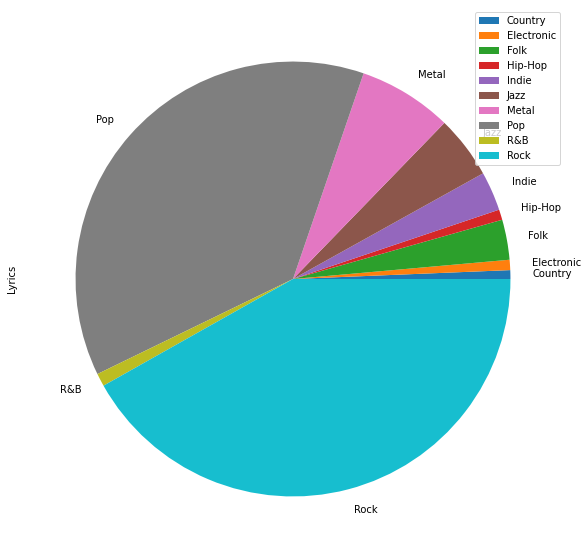

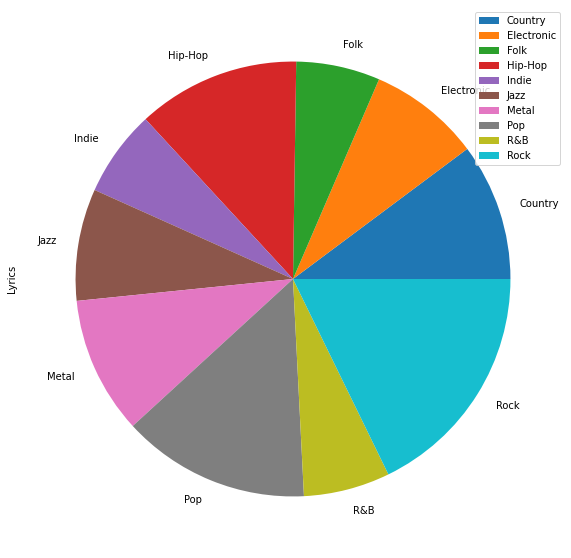

In [10]:
df_train.groupby(['Genre']).count().plot(kind='pie', y='Lyrics', figsize= (10,10))
df_test.groupby(['Genre']).count().plot(kind='pie', y='Lyrics', figsize= (10,10))


In [11]:
#train, test = train_test_split(df4, test_size=0.3)
train_lyrics = df_train['Lyrics_cleaned']
train_genre = df_train['Genre']
test_lyrics = df_test['Lyrics_cleaned']
test_genre = df_test['Genre']


In [21]:
pipe_lr_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                           lowercase=False,
                           analyzer='word')),
    ('lr', LogisticRegression())
])

pipe_lr_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              lowercase=False,
                              analyzer='word',
                              )), #ngram_range = (1,2)
    ('lr', LogisticRegression())
])

pipe_nb_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                           lowercase=False,
                           analyzer='word')),
    ('nb', MultinomialNB())
])

pipe_nb_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              lowercase=False,
                              analyzer='word')),
    ('nb', MultinomialNB())
])

pipe_svc_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                           lowercase=False,
                           analyzer='word')),
    ('svc',  LinearSVC())
])

pipe_svc_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              lowercase=False,
                              analyzer='word',
                              ngram_range = (1,2))),
    ('svc', LinearSVC())
])

pipe_sgd_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              lowercase=False,
                              analyzer='word',
                              ngram_range = (1,2))),
    ('svc', SGDClassifier())
])


pipelines = [pipe_lr_cv, pipe_lr_tf, pipe_nb_cv,
             pipe_nb_tf, pipe_svc_cv, pipe_svc_tf]

In [22]:
# Fit pipe
for pipe in pipelines:
   pipe.fit(X_train, y_train)
#pipe_svc_cv.fit(train_lyrics, train_genre) 

/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/oub/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [20]:
for pipe in pipelines:
    predicted = pipe.predict(X_test)
    print(confusion_matrix(y_test, predicted), '\n\n\n')


[[    3     0    12     0     1    12     2    43     0   210]
 [    0    17     3     1     3     5    29   115     2   157]
 [    6     1   154     4    23    53    43   231     2   780]
 [    0     1     0    31     2     4    10   244     5    39]
 [    0     7    17     3   101    17    54   343     5   720]
 [    3     9    33     7    11   921    12   225     4   807]
 [    2    10    18     9    26    15  1274   435     5  1249]
 [   18    42   107   155   128   287   374 10312    60  4822]
 [    0     0     7     2     3    19    14   178     9   187]
 [   63    35   287    35   199   438   688  3256    41 13167]] 



[[    0     0     1     0     0     7     0    39     0   236]
 [    0     0     0     0     0     1    16   120     0   195]
 [    0     0    17     0     0    17    19   212     0  1032]
 [    0     0     0     0     0     0     6   289     0    41]
 [    0     0     1     0     2     7    22   441     0   794]
 [    0     0     1     0     0   794     5   283 

In [23]:
methods = []

for pipe in pipelines:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    vect = pipe.steps[0][1].__class__.__name__.split('.')[-1]

    predicted = pipe.predict(X_test)
    accuracy = accuracy_score(predicted, y_test)
    conf_mat = confusion_matrix(y_test, predicted)

    methods.append([name, vect, accuracy, conf_mat])

methods = pd.DataFrame(methods)
methods.columns = ['Model', 'Vectorizer', 'Accuracy', "Confussion_Matrix"]
methods["Strategy"] = methods["Model"] + " -- " + methods["Vectorizer"]
methods.set_index(["Strategy"], inplace=True)

In [24]:
methods[["Model", "Vectorizer", "Accuracy"]]

,Model,Vectorizer,Accuracy
Strategy,,,
LogisticRegression -- CountVectorizer,LogisticRegression,CountVectorizer,0.600179
LogisticRegression -- TfidfVectorizer,LogisticRegression,TfidfVectorizer,0.618653
MultinomialNB -- CountVectorizer,MultinomialNB,CountVectorizer,0.583222
MultinomialNB -- TfidfVectorizer,MultinomialNB,TfidfVectorizer,0.539359
LinearSVC -- CountVectorizer,LinearSVC,CountVectorizer,0.568402
LinearSVC -- TfidfVectorizer,LinearSVC,TfidfVectorizer,0.656840


<AxesSubplot:title={'center':'Accuracy'}, xlabel='Strategy'>

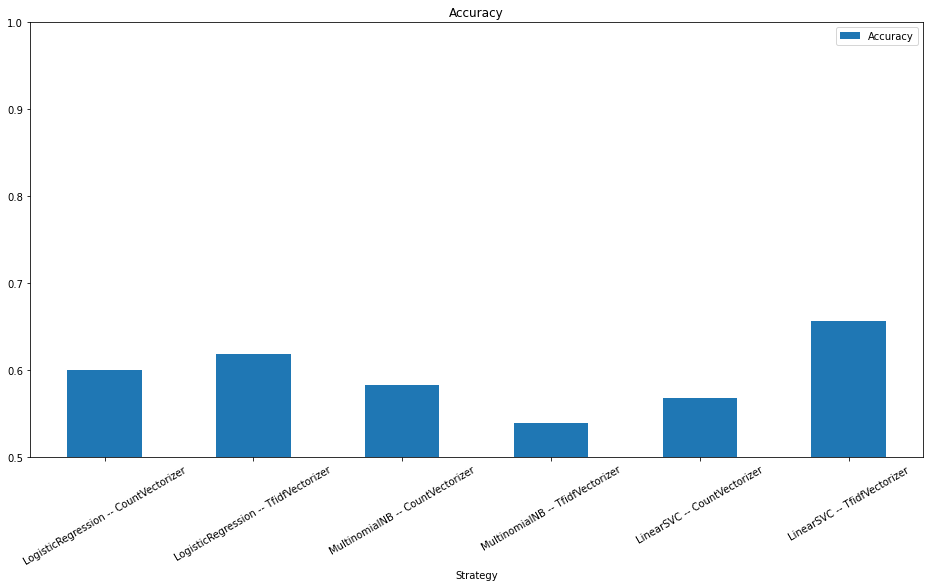

In [34]:
# %matplotlib inline
methods.plot(figsize=(16, 8), kind='bar', title='Accuracy',
             rot=30, ylim=(0.5, 1), colormap='tab10')

In [64]:
pipe_sgd_tf.fit(X_train, y_train) 

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('svc', SGDClassifier())])

In [66]:

predicted = pipe_sgd_tf.predict(X_test)
accuracy = accuracy_score(predicted, y_test)
print(accuracy)

0.5974082668933667


In [49]:
import joblib

joblib.dump(pipe_svc_tf, 'pipe_svc_tf_0658.pkl') 


['pipe_svc_tf_0658.pkl']

## GridSearchCV

In [62]:
pipe_svc_tf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'svc', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'svc__C', 'svc__class_weight', 'svc__dual', 'svc__fit_intercept', 'svc__intercept_scaling', 'svc__loss', 'svc__max_iter', 'svc__multi_class', 'svc__penalty', 'svc__random_state', 'svc__tol', 'svc__verbose'])

In [22]:
from sklearn.experimental import enable_halving_search_cv # noqa
 # now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

In [63]:
grid = {
   # 'svc__loss': ['squared_hinge'], #'modified_huber'
   # 'svc__penalty': ['elasticnet']
}

gs = HalvingGridSearchCV(pipe_svc_tf, 
                        param_grid=grid,
                        scoring='accuracy', 
                        n_jobs=-1)

In [64]:
gs.fit(train_lyrics, train_genre)

HalvingGridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(lowercase=False,
                                                               stop_words='english')),
                                              ('svc', LinearSVC(C=2))]),
                    n_jobs=-1, param_grid={},
                    refit=<function _refit_callable at 0x7fd1e2cfa3a0>,
                    scoring='accuracy')

In [65]:
gs.cv_results_


{'iter': array([0]),
 'n_resources': array([290148]),
 'mean_fit_time': array([439.51652145]),
 'std_fit_time': array([392.71483511]),
 'mean_score_time': array([12.63487477]),
 'std_score_time': array([3.74240681]),
 'params': [{}],
 'split0_test_score': array([0.60492849]),
 'split1_test_score': array([0.62045494]),
 'split2_test_score': array([0.62038601]),
 'split3_test_score': array([0.58684451]),
 'split4_test_score': array([0.56144342]),
 'mean_test_score': array([0.59881147]),
 'std_test_score': array([0.02240936]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score': array([0.74500039]),
 'split1_train_score': array([0.74484529]),
 'split2_train_score': array([0.74878725]),
 'split3_train_score': array([0.76639138]),
 'split4_train_score': array([0.77082876]),
 'mean_train_score': array([0.75517061]),
 'std_train_score': array([0.01115236])}

In [12]:
gs.best_estimator_.steps[0][1]  # best model


TfidfVectorizer(lowercase=False, stop_words='english')

In [67]:
gs.best_params_

{}

In [66]:
pred = gs.predict(test_lyrics)


accuracy = accuracy_score(pred, test_genre)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.2977


In [34]:
def predictor(string, train=df_train['Lyrics_cleaned'], model=pipe_svc_tf):
    """given a string predict a genre based on the lyrics and best trained model (or a given ones). 
    """
    pred = model.predict([clean_lyrics(string)])
    return list(pred)

In [35]:
mystery1 = """Got a little boom in my big truck
Gonna open up the doors and turn it up
Gonna stomp my boots in the Georgia mud
Gonna watch you make me fall in love
Get up on the hood of my daddy's tractor
Up on the tool box, it don't matter
Down on the tailgate
Girl I can't wait
To watch you do your thing
"""


In [36]:
predictor(mystery1)

['Rock']

In [37]:
mystery2 = """Oh, sometimes
I get a good feeling, yeah
Get a feeling that I never, 
never, never, never had before, no no
I get a good feeling, yeah
"""

In [38]:
predictor(mystery2)

['Pop']

In [61]:
mystery3 = """Don't forget our Monday date
Oh little baby, don't be late
I said don't forget our Monday date
At the same little place, about half past eight

Now I'm gonna press my suit
I'm gonna shine my shoes
I'm gonna spread the news
And I'm gonna chase away the blues
So don't forget our Monday date
Please, baby, don't be late
"""

In [62]:
predictor(mystery3)


['Rock']

In [41]:
mystery4 = """How many brothers fell victim to the streets?
Rest in peace, young nigga, there's a heaven for a G
Be a lie If I told you that I never thought of death
My niggas, we the last ones left, but life goes on
How many brothers fell victim to the streets?
Rest in peace, young nigga, there's a heaven for a G
Be a lie If I told you that I never thought of death"""

In [42]:
predictor(mystery4)

['Pop']

In [47]:
mystery5 ="""ve felt the hate rise up in me
Kneel down and clear the stone of leaves
I wander out where you can't see
Inside my shell, I wait and bleed

I've felt the hate rise up in me
Kneel down and clear the stone of leaves
I wander out where you can't see
Inside my shell, I wait and bleed"""

In [48]:
predictor(mystery5)

['Metal']

In [45]:
mystery6 = """Empty spaces.
What are we living for?
Abandoned places.
I guess we know the score.

On and on.
Does anybody know what we are looking for?

Another hero,
Another mindless crime
Behind the curtain
In the pantomime.
"""

In [46]:
predictor(mystery6)

['Rock']

In [68]:
model_from_joblib = joblib.load('pipe_svc_tf_0658.pkl')
print(model_from_joblib.predict([mystery6]))

['Rock']
